Import the required libraries:

In [540]:
using Graphs
using Bloqade
using Random
using GenericTensorNetworks
using Optim
using PythonCall
plt = pyimport("matplotlib.pyplot");

# Task 3: Maximum Independent Set (MIS)

## Background

In graph theory, an independent set means no two vertices in a graph belong to the same set can be connected by an edge. A maximal independent set (MIS) is the largest independent set out of all independent sets. Usually, the MIS problems are NP-hard or non-deterministic polynomial-time hard problems which is unlikely to be solved in a time polynomial to the problem size. Interestingly, this NP-hard problems can be addressed on Rydberg atom arrays thanks to the Rydberg Blockade phenomenon in neutral-atom Rydberg states. 

Rydberg blockade is triggered due to the strong interaction between atoms excited to Rydberg state. If two atoms are within the blockade radius $R_b$ then they cannot be both excited to the Rydberg state. Independent set constraint means two vertices cannot be both in the independent set when they are connected by an edge. Thus Rydberg atoms can be considered as the independent vertices and the solutions of MIS problems can be efficiently encoded in the ground state of interacting atoms in 2D arrays by utilizing the Rydberg blockade mechanism.

## 1. Solve the 4 X 4 DUGG Problem

We follow the steps in this [tutorial](https://github.com/QuEraComputing/Bloqade.jl/blob/master/examples/4.MIS/main.jl) to solve the problems in task 3.
We first create a 4x4 diagonal-connected unit-disk grid graphs (DUGG) with 0.8 filling, by using the random_dropout function. Here, we choose the lattice constant $a$ to be 4.5 $\mu$m:

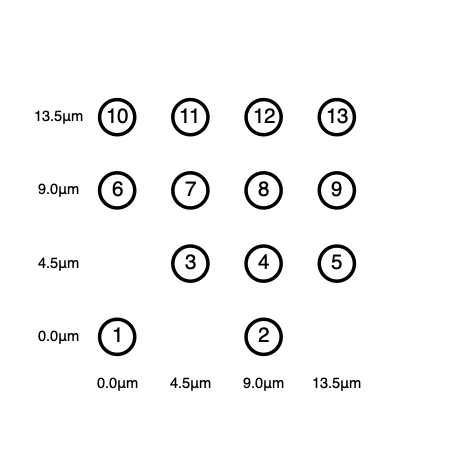

In [580]:
Random.seed!(2)
atoms = generate_sites(SquareLattice(), 4, 4; scale = 4.5) |> random_dropout(0.2)

Next, we set the blockade radius to be 7.5 $\mu$m, such that all nearest neighbors and next-nearest neighbors (diagonal) are within the blockade radius. The mechanism of Rydberg Blockade only allows one Rydberg excitation in the blockade radius. Therefore two vertices connected by the same edge should never be chosen simultaneously in the same independent set.

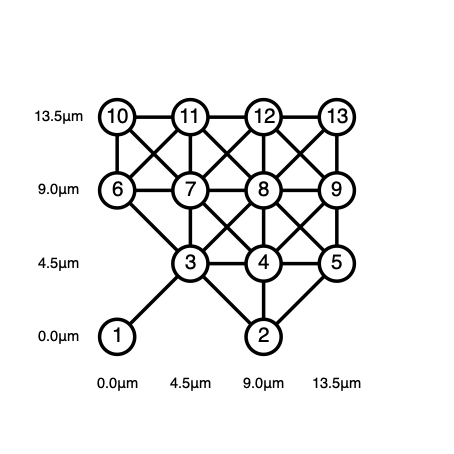

In [542]:
Bloqade.plot(atoms, blockade_radius = 7.5)

### Classical Algorithm: Generic Tensor Network

In order to compare the quantum algorithms with the classical algorithms to calculate the MIS size, we first solve the exact MIS and its degenarcy using generic tensor network algorithm in the package GenericTensorNetworks

In [543]:
graph = BloqadeMIS.unit_disk_graph(atoms, 7.5)
mis_size_and_counting = GenericTensorNetworks.solve(IndependentSet(graph), CountingMax())[]

(4.0, 26.0)ₜ

The result shows the MIS size is 4 and number of MIS is 26

### Quantum Algorithm: Bloqade

Use adiabatic approach, set up Rabi frequency $\Omega$, detuning $\Delta$ and time T_max.

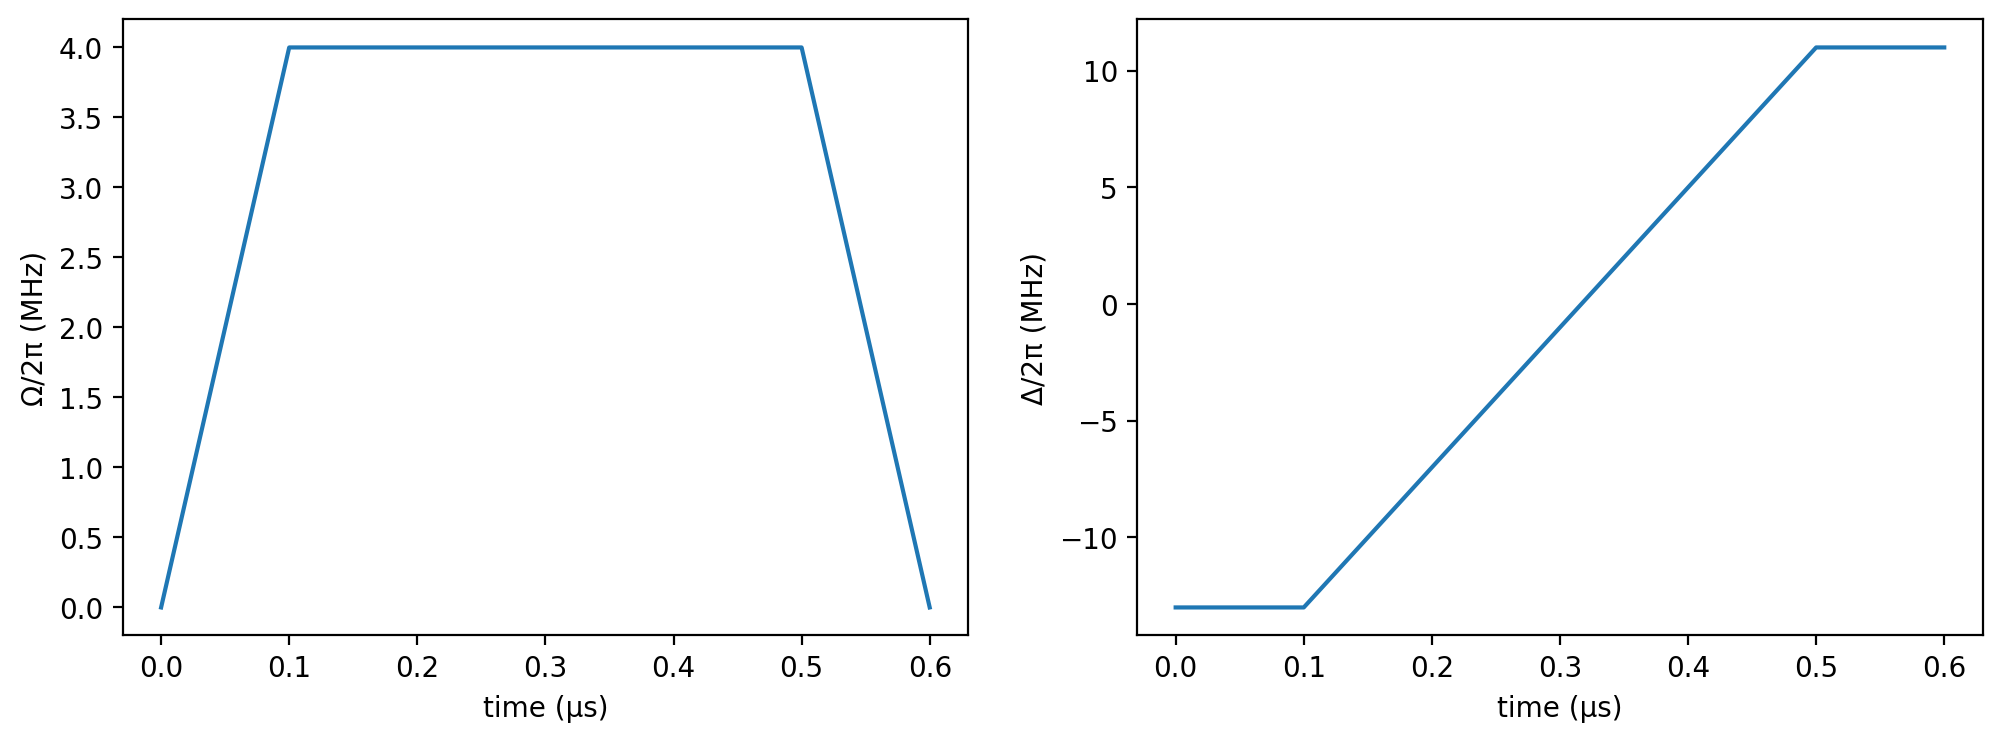

In [544]:
T_max = 0.6
Ω_max = 2π * 4
Ω = piecewise_linear(clocks = [0.0, 0.1, 0.5, T_max], values = [0.0, Ω_max, Ω_max, 0])
Δ_start = -2π * 13
Δ_end = 2π * 11
Δ = piecewise_linear(clocks = [0.0, 0.1, 0.5, T_max], values = [Δ_start, Δ_start, Δ_end, Δ_end])

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12, 4))
Bloqade.plot!(ax1, Ω)
ax1.set_ylabel("Ω/2π (MHz)")
Bloqade.plot!(ax2, Δ)
ax2.set_ylabel("Δ/2π (MHz)")
fig

Set up the time-dependent Hamiltonian and simulate its time evolution by using the SchrodingerProblem solver:

In [545]:
hamiltonian = rydberg_h(atoms; Ω = Ω, Δ = Δ)# create the Rydberg Hamiltonian
nsites=nqubits(hamiltonian)#extract the number of sites from the Rydberg Hamiltonian
reg=zero_state(nsites)# specify all atoms to be in the |0> state initially
prob = SchrodingerProblem(reg, T_max, hamiltonian)# and set up the emulation problem by choosing an ODE solver:
emulate!(prob)

SchrodingerProblem:
  register info:
    type: ArrayReg{2, ComplexF64, Matrix{ComplexF64}}
    storage size: 8 bytes

  time span (μs): (0.0, 0.6)

  equation: 
    storage size: 1.688 MiB
    expression:
nqubits: 13
+
├─ [+] ∑ 2π ⋅ 8.627e6.0/|r_i-r_j|^6 n_i n_j
├─ [+] Ω(t) ⋅ ∑ σ^x_i
└─ [-] Δ(t) ⋅ ∑ n_i


  options:
    save_everystep: false
    save_start: false
    save_on: false
    dense: false


Plot the most probable bitstrings by using the bitstring_hist function on the resulting register

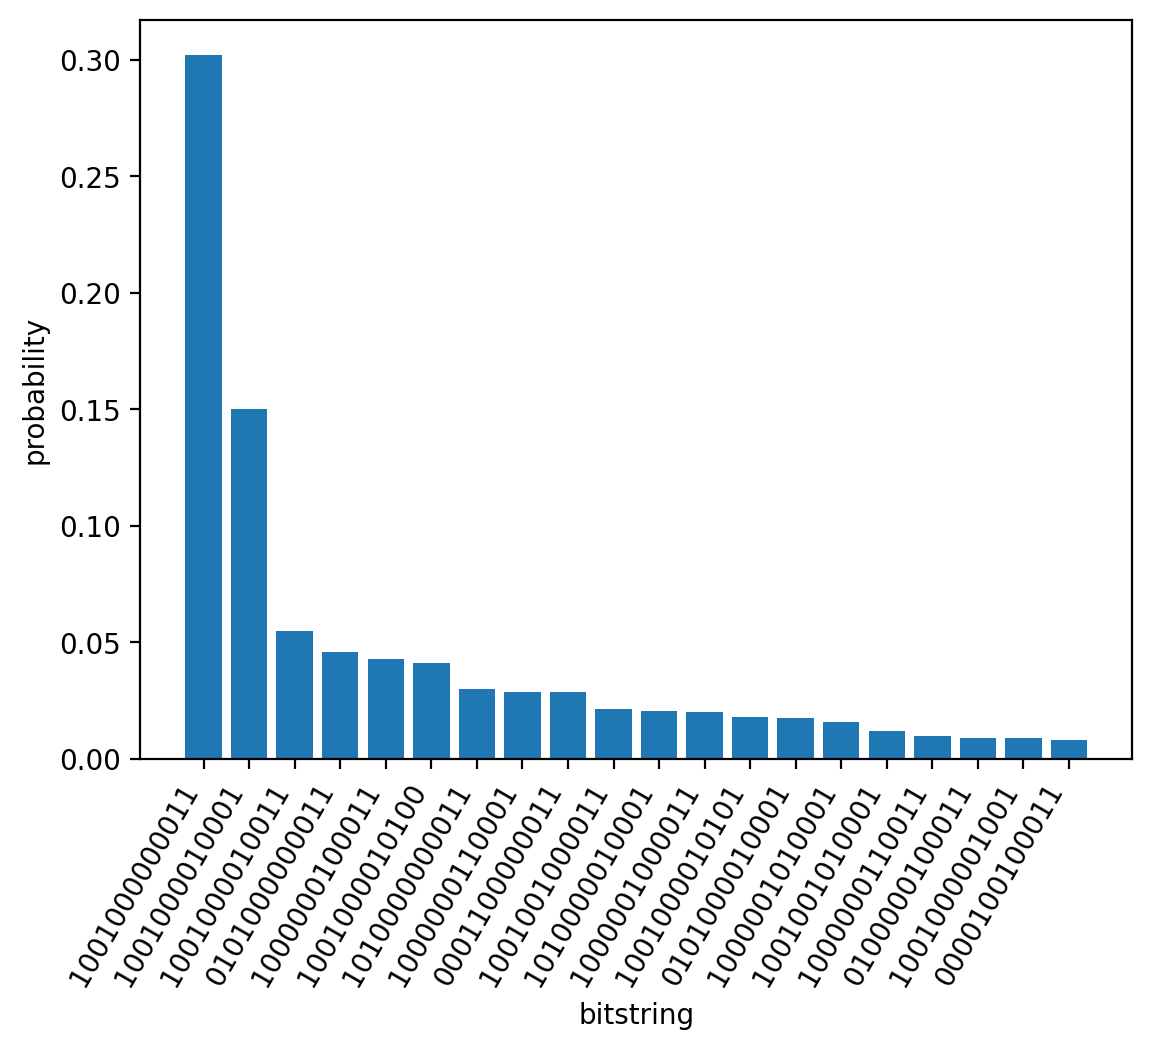

In [546]:
bitstring_hist(prob.reg; nlargest = 20)

In this histogram, we see the frist two most probable bitstrings have an independent set size 4 by counting the number of ones in the bitstring.  

Next, we use rydberg_density_sum to calculate mean MIS size, if the value of the calculated mean MIS is close to the size of the MIS, which means there is a substantial probability for measuring an MIS state.

In [547]:
rydberg_density_sum(prob.reg)

4.1557282370196935

We can futher visulize the configuration by coloring the Rydberg excitations on the 4x4 graph. 

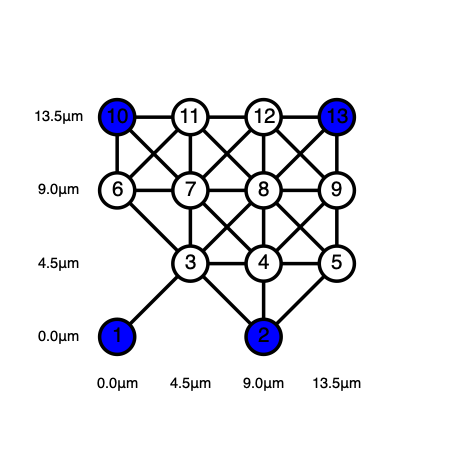

In [548]:
best_bit_strings = most_probable(prob.reg, 3)
Bloqade.plot(atoms, blockade_radius = 7.5; colors = [iszero(b) ? "white" : "blue" for b in best_bit_strings[1]])

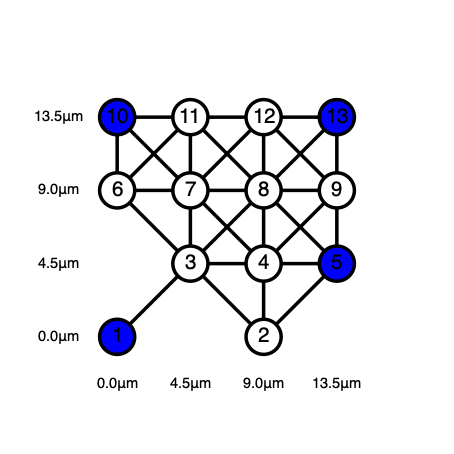

In [549]:
Bloqade.plot(atoms, blockade_radius = 7.5; colors = [iszero(b) ? "white" : "blue" for b in best_bit_strings[2]])

In the first two plots, MIS equals to 4 which is the same as the prediction from the generic tensor network alogrithm. However, mismatch happens in the third bitstring with 5 ones in it. This indicates a violation of the blockade constraint as shown in the figure below.

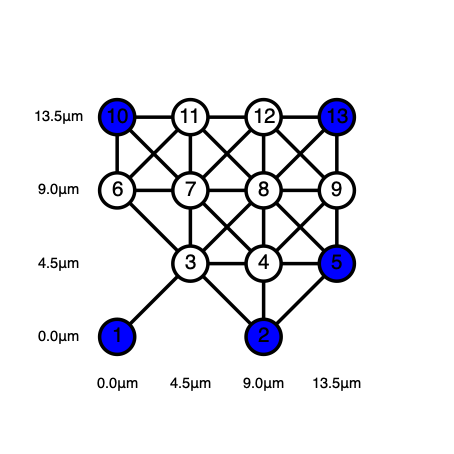

In [550]:
Bloqade.plot(atoms, blockade_radius = 7.5; colors = [iszero(b) ? "white" : "blue" for b in best_bit_strings[3]])

This could due to the two vertices are on the edge of the unit disk where the Rydberg interaction is not strong enough to trigger the energy penalty.
We can check the independency in each bitstring using the BloqadeMIS.is_independent_set function:

In [551]:
#Here we check the independence constraint in the first 5 bitstring.
best5_bit_strings = most_probable(prob.reg, 5)
BloqadeMIS.is_independent_set.(best5_bit_strings, Ref(graph))

5-element BitVector:
 1
 1
 0
 1
 1

This can be fixed by performing some postprocessing to reduce the violated configurations to indendendent set configurations using the mis_postprocessing function.

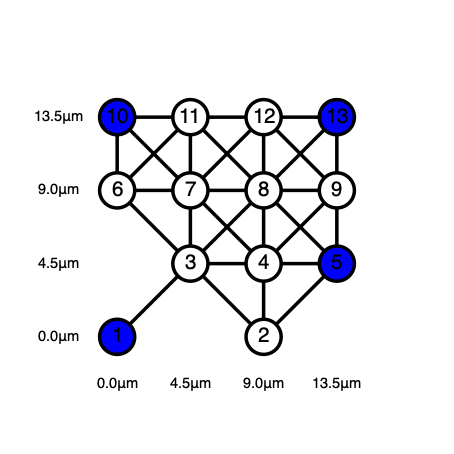

In [552]:
fixed = mis_postprocessing(best5_bit_strings[3], graph)
Bloqade.plot(atoms, blockade_radius = 7.5; colors = [iszero(b) ? "white" : "blue" for b in fixed])

Then the independence constraint test gives us Ture

In [553]:
BloqadeMIS.is_independent_set(fixed, graph)

true

## 2. Pulse parameterizations for optimizing the Rydberg Hamiltonian

The Rydberg blockade radius can be computed via equation:
$$
    C_6 / R_b^6 \sim \sqrt{\Delta^2 + \Omega^2}
$$
where $\Delta$ is the detuning and $\Omega$ is the Rabi frequency between the ground state and Rydberg excitation state. This equation indicats pulse parameterization is avaible using $\Delta$ and $\Omega$.

Here, we use T_max = 0.6 $\mu$s, and we fix $\Omega$_max and $\Delta$_start. We further create a function to parametrize the pulses by adjusting coefficients in x0 and x1. This function returns density, parametrized $\Omega$ and $\Delta$.

In [554]:
function optimized_hamiltonian(atoms::AtomList, x0, x1)
    T_max=0.6
    Ωo = piecewise_linear(clocks = [0.0,0.05,0.1,0.15,0.45,0.5, 0.55, T_max], values = [0.0,0.0,x0[1]*Ω_max, Ω_max, Ω_max, x0[2]*Ω_max,0.0,0.0])
    Δ_start = -2π * 13
    Δ_end = 2π * 11
    Δ0 = 2π * 11
    Δo = piecewise_linear(clocks = [0.0, 0.05, 0.2, 0.3, 0.4, 0.55, T_max], values = [Δ_start, Δ_start, Δ0*x1[1], Δ0*x1[2], Δ0*x1[3], Δ_end, Δ_end])


    hamiltonianop = rydberg_h(atoms; Ω = Ωo, Δ = Δo)
    nsitesop=nqubits(hamiltonianop)
    regop=zero_state(nsites)
    probop = SchrodingerProblem(regop, T_max, hamiltonianop)
    emulate!(probop)

    integratorop = init(probop, Vern8());
    densitiesop = [];
    for _ in TimeChoiceIterator(integratorop, 0.0:1e-3:T_max)
        push!(densitiesop, rydberg_density(regop))
    end
    return hcat(densitiesop...), probop.reg, Ωo, Δo
end


optimized_hamiltonian (generic function with 2 methods)

In [555]:
x0=[0.8, 0.8];#coefficients of Ω at certain time
x1=[0.1,0.5,0.8];#coefficients of Δ at certain time
D1,regop,Ωop, Δop = optimized_hamiltonian(atoms, x0, x1)

([0.0 0.0 … 0.9354827742067553 0.9354827744723634; 0.0 0.0 … 0.5069263223585647 0.5069263404149236; … ; 0.0 0.0 … 0.028353302450946992 0.02835332053542266; 0.0 0.0 … 0.9229331421088118 0.9229331601932782], ArrayReg{2, ComplexF64, Array...}
    active qubits: 13/13
    nlevel: 2, Waveform(_, 0.6), Waveform(_, 0.6))

Plot parametrized Rabi frequency $\Omega$ and detuning $\Delta$

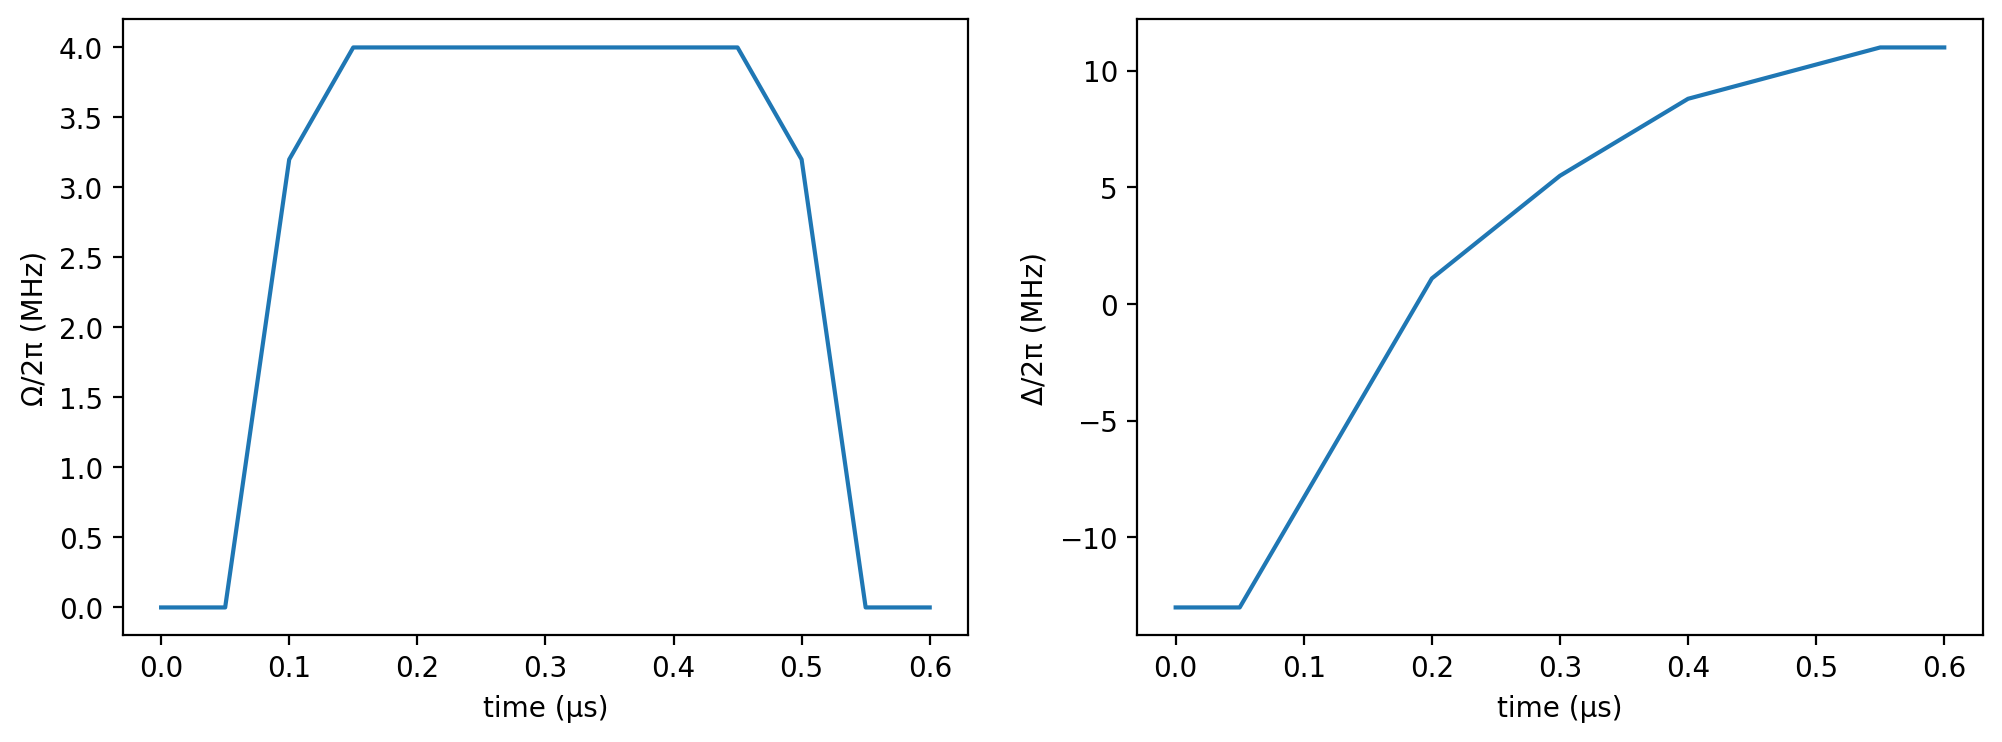

In [556]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12, 4))
Bloqade.plot!(ax1, Ωop)
ax1.set_ylabel("Ω/2π (MHz)")
Bloqade.plot!(ax2, Δop)
ax2.set_ylabel("Δ/2π (MHz)")
fig.savefig("Parameters.png", bb_inches="tight")
fig

Plot the time-dependent dynamics of Rydberg density for each site:

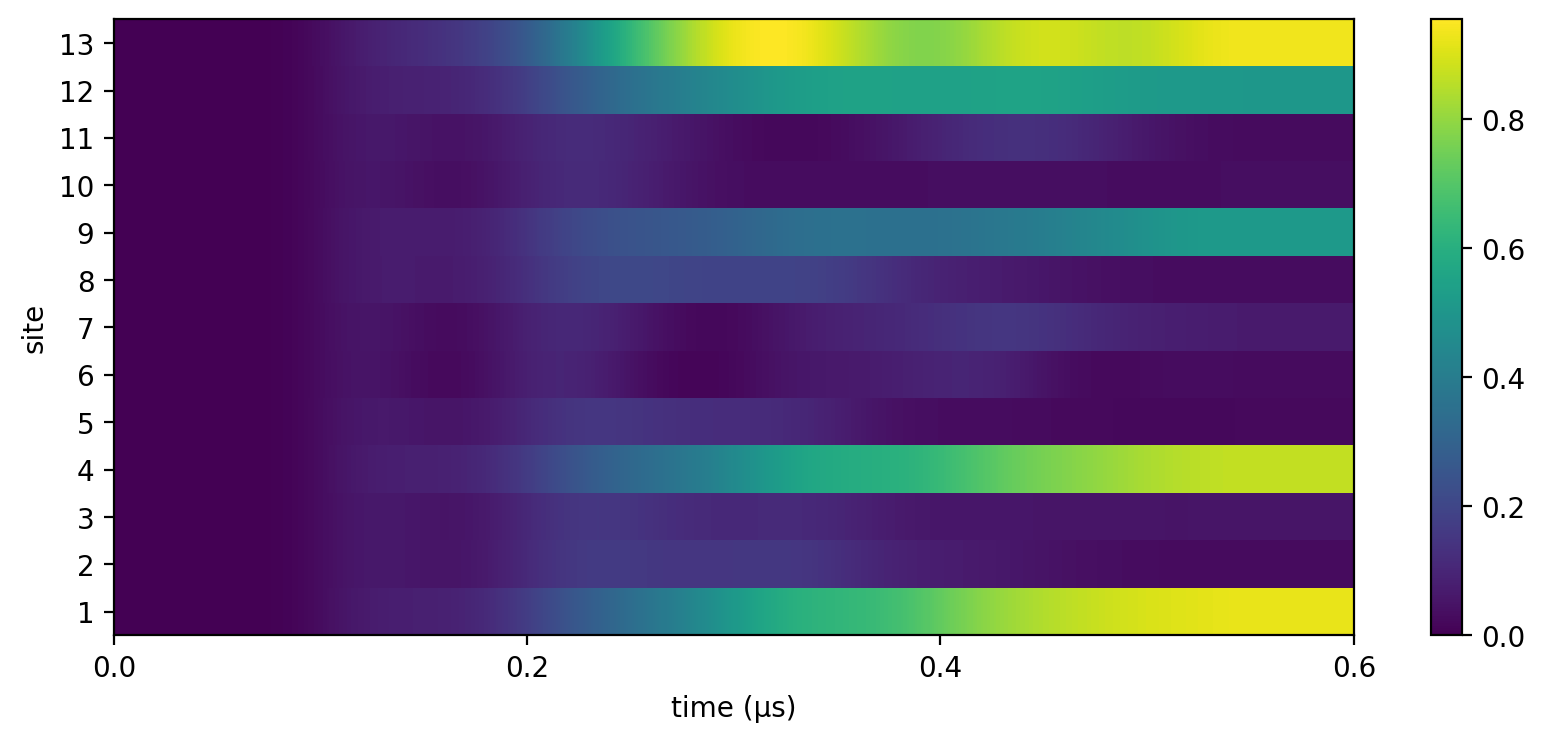

In [557]:
fig2, ax = plt.subplots(figsize = (10, 4))
shw = ax.imshow(real(D1), interpolation = "nearest", aspect = "auto", extent = [0, T_max, 0.5, nsites + 0.5])
ax.set_xlabel("time (μs)")
ax.set_ylabel("site")
ax.set_xticks(0:0.2:T_max)
ax.set_yticks(1:nsites)
bar = fig2.colorbar(shw)
fig2

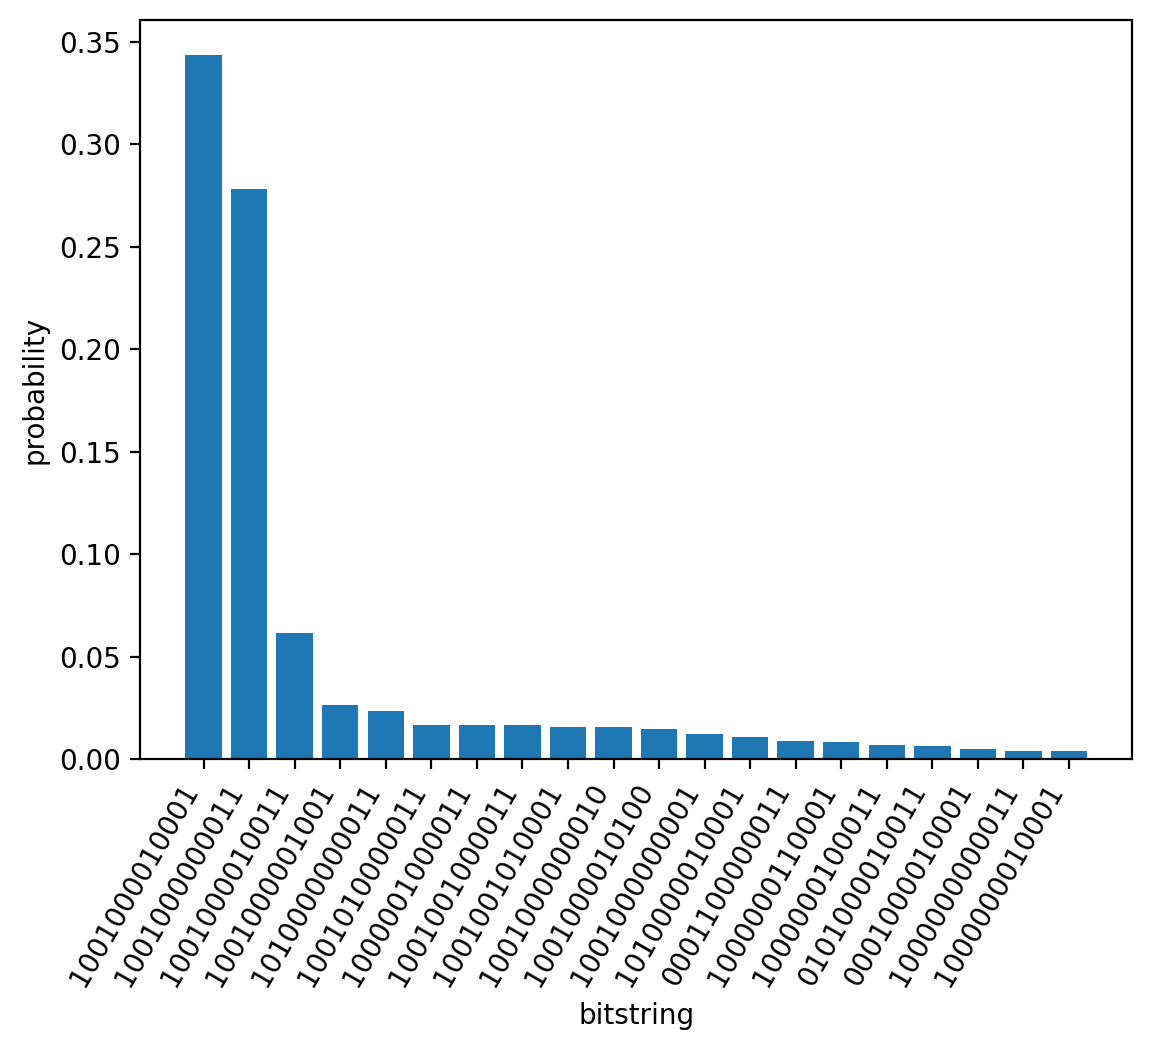

In [558]:
bitstring_hist(regop; nlargest = 20)

Calculate mean MIS size

In [559]:
rydberg_density_sum(regop)

4.052015145184147

## 3. Smoothened picecwise linear pulses

A smoothened piecewise linear waveform can be created by applying a Gaussian filter on a waveform created by the piecewise_linear function.

In [560]:
function smoothened_pulse_hamiltonian(atoms::AtomList, x1)
    T_max=0.6
    Ωs = smooth(piecewise_linear(clocks = [0.0, 0.05, 0.1, 0.5, 0.55, T_max], values = [0, 0, Ω_max, Ω_max, 0, 0]); kernel_radius = 0.02,)
    Δ_start = -2π * 13
    Δ_end = 2π * 11
    Δ0 = 2π * 11
    Δs = smooth(piecewise_linear(clocks = [0.0, 0.05, 0.2, 0.3, 0.4, 0.55, T_max], values = [Δ_start, Δ_start, Δ0*x1[1], Δ0*x1[2], Δ0*x1[3], Δ_end, Δ_end]); kernel_radius = 0.02,)


    hamiltonianop = rydberg_h(atoms; Ω = Ωo, Δ = Δo)
    nsitesop=nqubits(hamiltonianop)
    regop=zero_state(nsites)
    probop = SchrodingerProblem(regop, T_max, hamiltonianop)
    emulate!(probop)

    integratorop = init(probop, Vern8());
    densitiesop = [];
    for _ in TimeChoiceIterator(integratorop, 0.0:1e-3:T_max)
        push!(densitiesop, rydberg_density(regop))
    end
    return hcat(densitiesop...), probop.reg, Ωs, Δs
end
x1 = [0.1, 0.8, 0.8]; # initial point for the optimization

In [561]:
D2,regs,Ωs, Δs = smoothened_pulse_hamiltonian(atoms, x1)

([0.0 0.0 … 0.9479992264733615 0.9480016661261497; 0.0 0.0 … 0.456662245924745 0.456652563292828; … ; 0.0 0.0 … 0.027618072580804183 0.027618748000451845; 0.0 0.0 … 0.898151590574481 0.8981605994176765], ArrayReg{2, ComplexF64, Array...}
    active qubits: 13/13
    nlevel: 2, Waveform(_, 0.6), Waveform(_, 0.6))

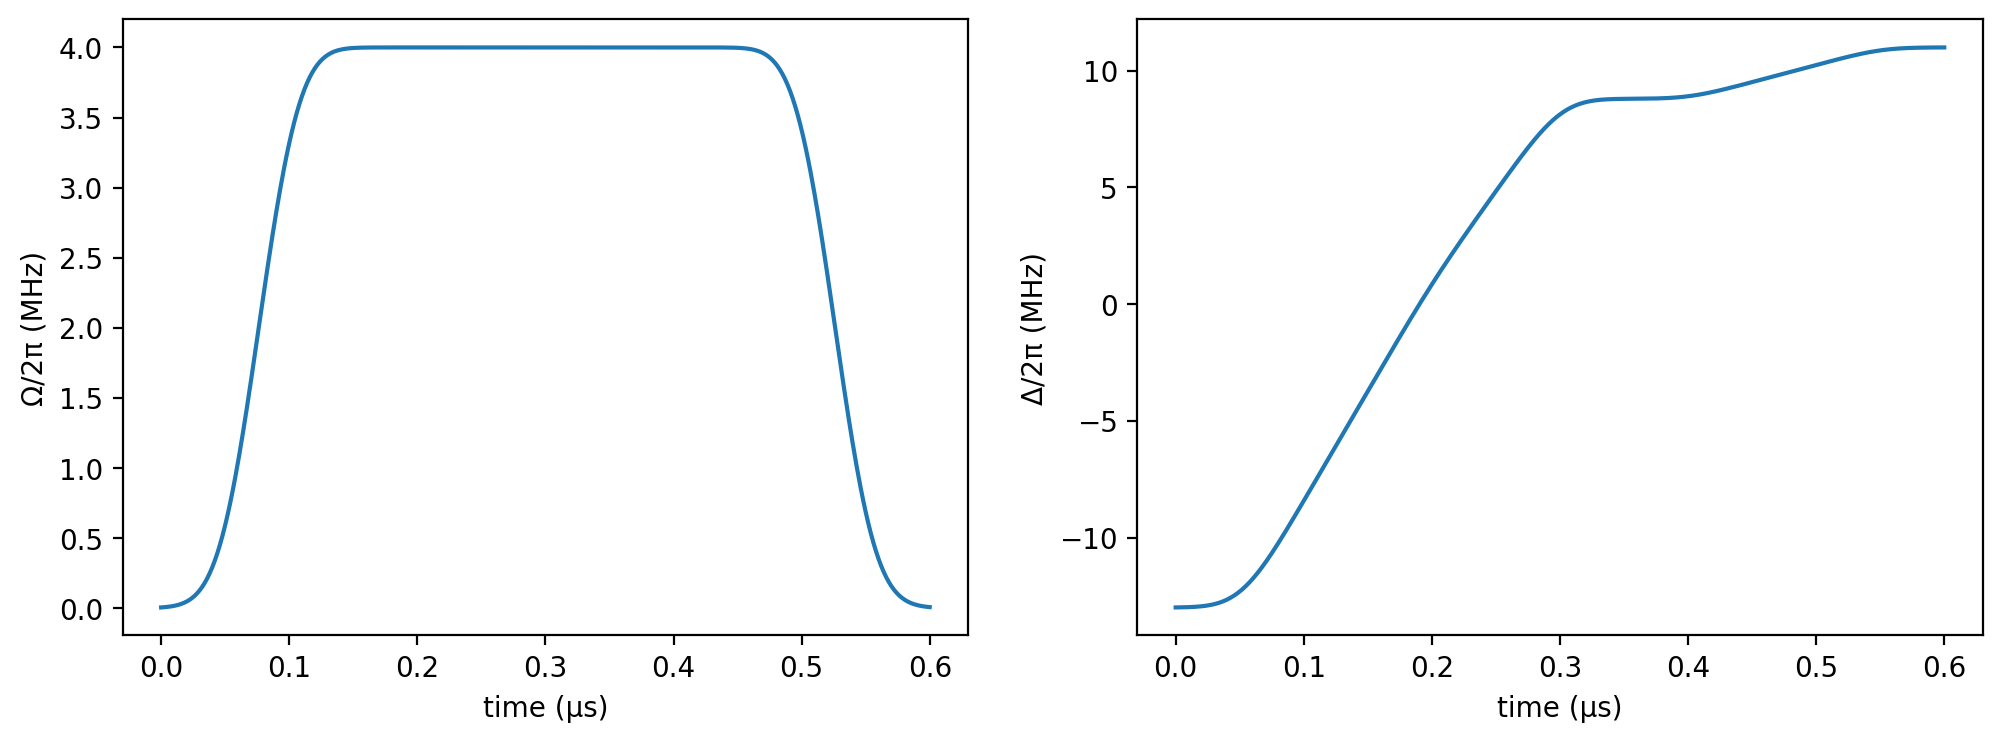

In [562]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12, 4))
Bloqade.plot!(ax1, Ωs)
ax1.set_ylabel("Ω/2π (MHz)")
Bloqade.plot!(ax2, Δs)
ax2.set_ylabel("Δ/2π (MHz)")
fig.savefig("Gaussian_filter.png", bb_inches="tight")
fig

Plot the time-dependent dynamics of Rydberg density for each site:

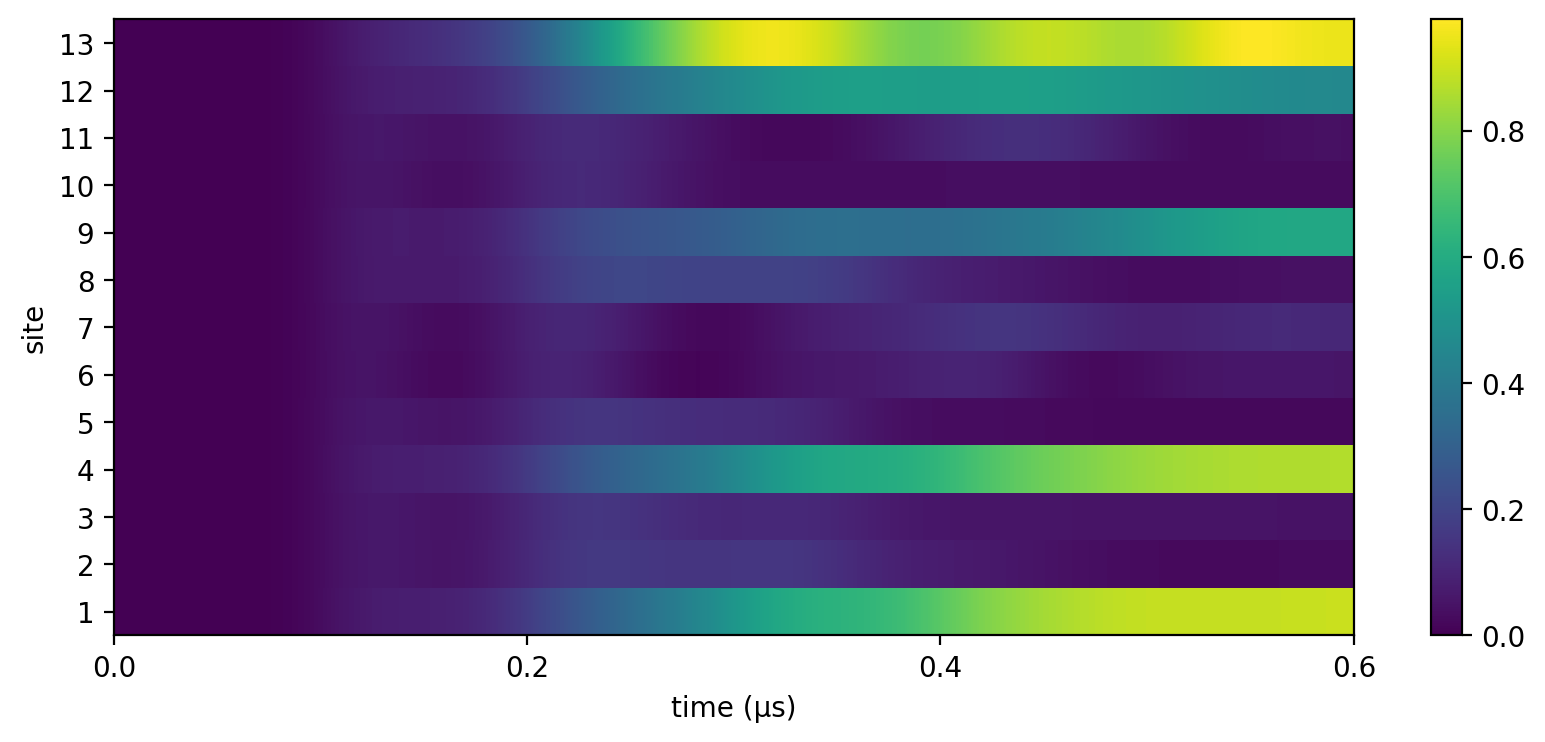

In [563]:
fig2, ax = plt.subplots(figsize = (10, 4))
shw = ax.imshow(real(D2), interpolation = "nearest", aspect = "auto", extent = [0, T_max, 0.5, nsites + 0.5])
ax.set_xlabel("time (μs)")
ax.set_ylabel("site")
ax.set_xticks(0:0.2:T_max)
ax.set_yticks(1:nsites)
bar = fig2.colorbar(shw)
fig2

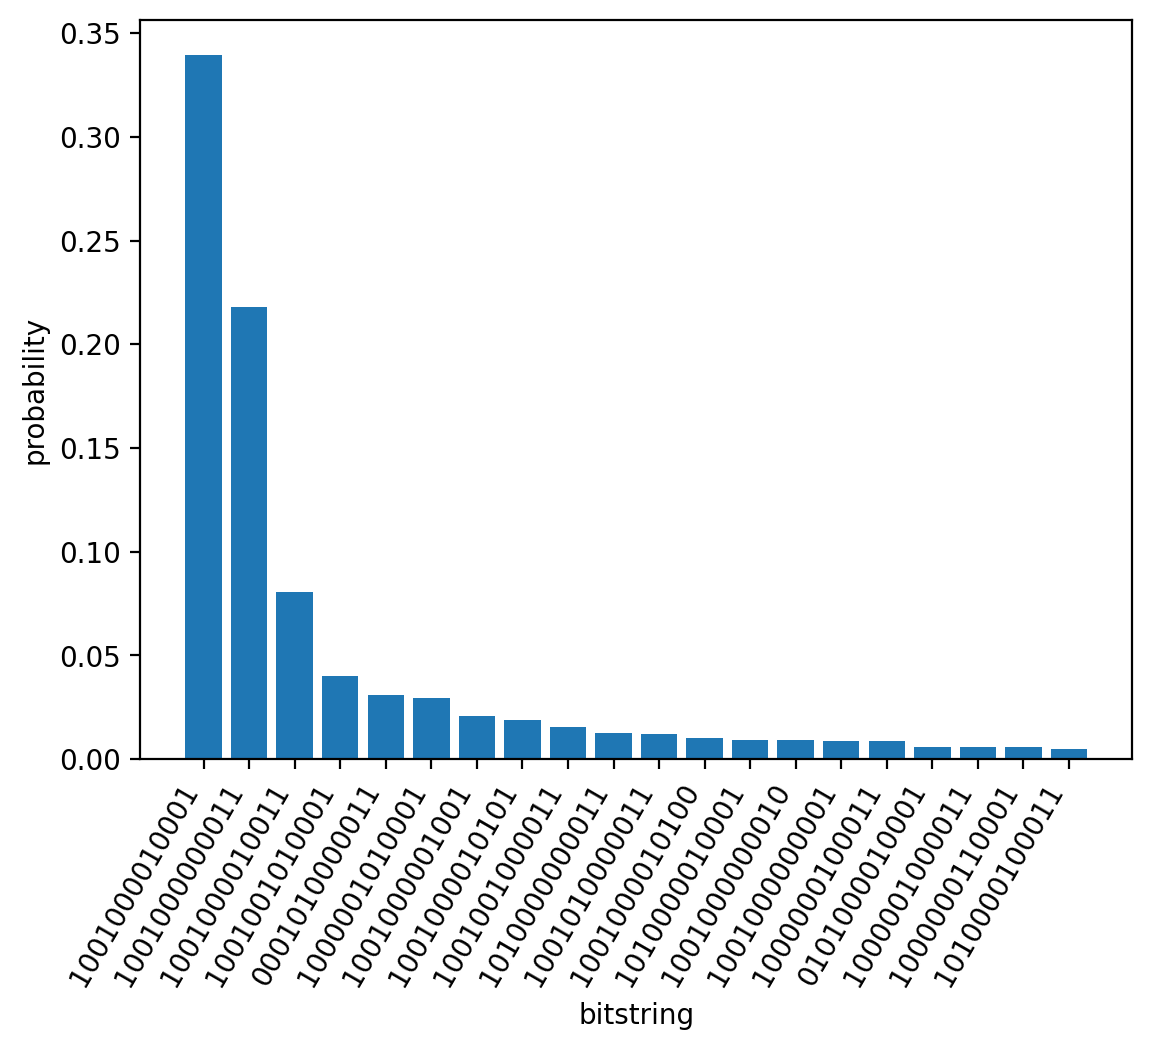

In [564]:
bitstring_hist(regs; nlargest = 20)

Calculate mean MIS size

In [565]:
rydberg_density_sum(regs)

4.124559376647529

# 4. Try a larger Array

Now we will generate a 5x5 diagonal-connected unit-disk grid graphs (DUGG) with 0.68 filling, by using the random_dropout function. Here, we choose the lattice constant $a$ to be 4.5 $\mu$m:

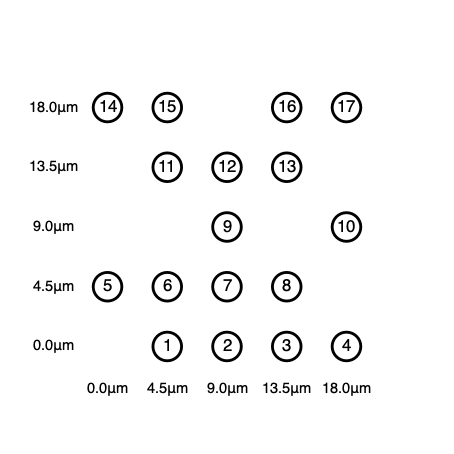

In [566]:
Random.seed!(3)
atomsnew = generate_sites(SquareLattice(), 5, 5; scale = 4.5) |> random_dropout(0.32)

Next, we set the blockade radius to be 7.5 $\mu$m, such that all nearest neighbors and next-nearest neighbors (diagonal) are within the blockade radius. The mechanism of Rydberg Blockade only allows one Rydberg excitation in the blockade radius. Therefore two vertices connected by the same edge should never be chosen simultaneously in the same Independet set.

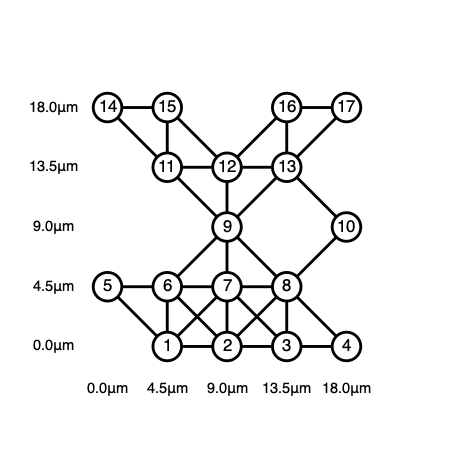

In [567]:
Bloqade.plot(atomsnew, blockade_radius = 7.5)

### Classical Algorithm: Generic Tensor Network

In [568]:
graphnew = BloqadeMIS.unit_disk_graph(atomsnew, 7.5)
mis_size_and_counting = GenericTensorNetworks.solve(IndependentSet(graphnew), CountingMax())[]

(7.0, 6.0)ₜ

### Use quantum algorithm: Bloqade

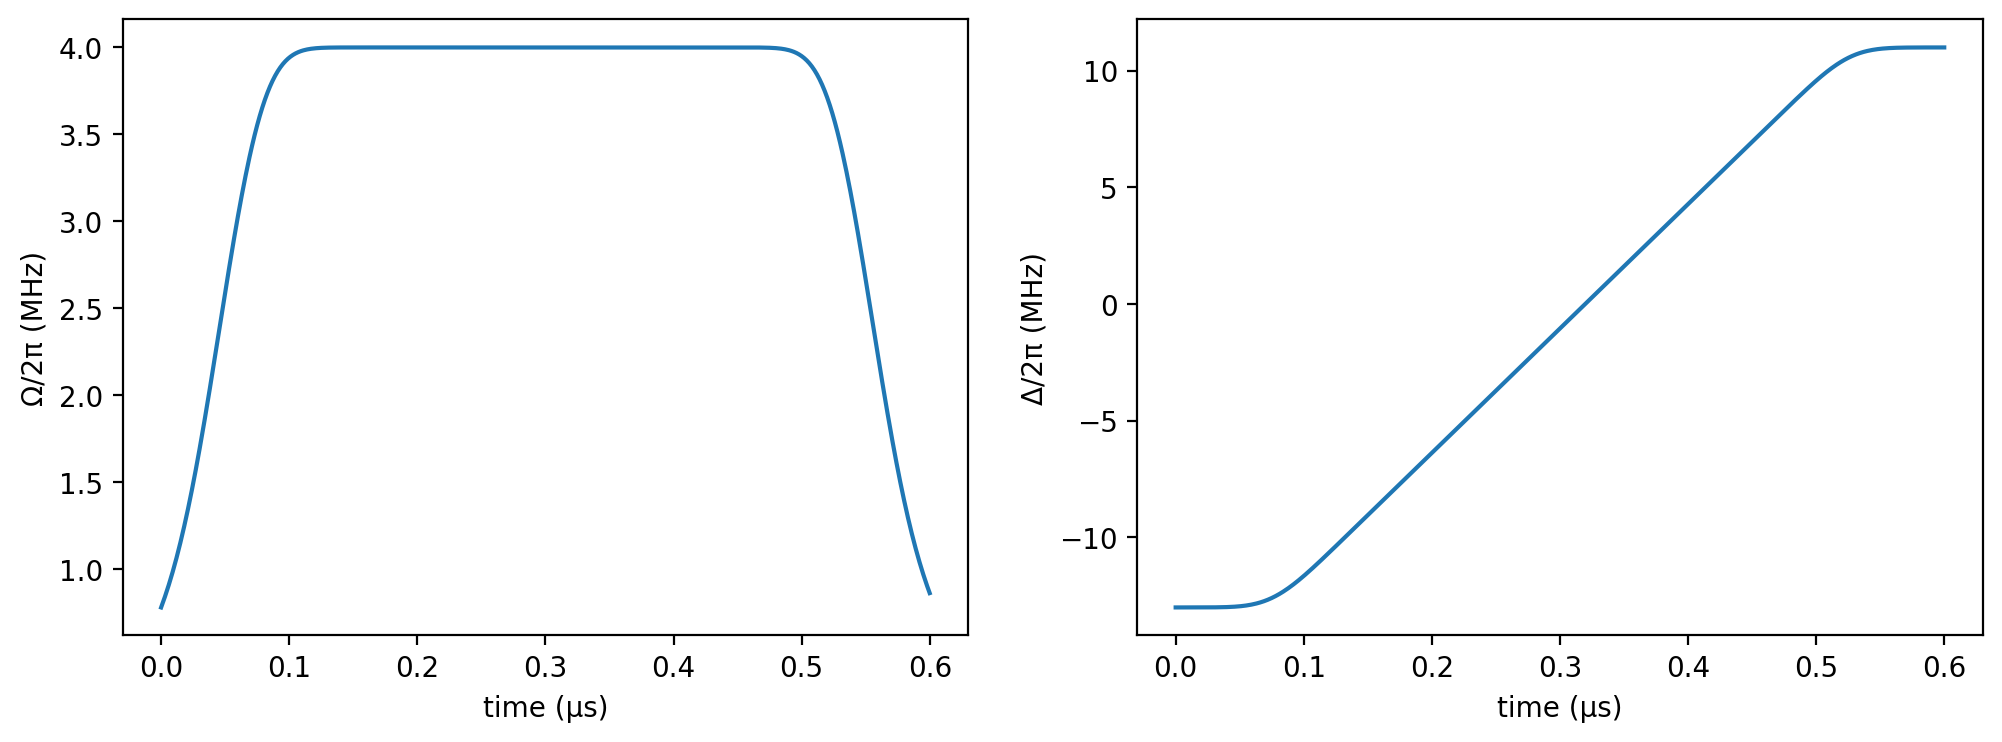

In [569]:
T_max = 0.6
Ω_max = 2π * 4
Ω = smooth(piecewise_linear(clocks = [0.0, 0.125*T_max, 0.875*T_max, T_max], values = [0.0, Ω_max, Ω_max, 0]); kernel_radius=0.02,)
Δ_start = -2π * 13
Δ_end = 2π * 11
Δ = smooth(piecewise_linear(clocks = [0.0, 0.125*T_max, 0.875*T_max, T_max], values = [Δ_start, Δ_start, Δ_end, Δ_end]); kernel_radius=0.02,)

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12, 4))
Bloqade.plot!(ax1, Ω)
ax1.set_ylabel("Ω/2π (MHz)")
Bloqade.plot!(ax2, Δ)
ax2.set_ylabel("Δ/2π (MHz)")
fig

In [570]:
hamiltoniannew = rydberg_h(atomsnew; Ω = Ω, Δ = Δ)
nsites=nqubits(hamiltoniannew)
regnew=zero_state(nsites)
prob = SchrodingerProblem(regnew, T_max, hamiltoniannew)
emulate!(prob)

SchrodingerProblem:
  register info:
    type: ArrayReg{2, ComplexF64, Matrix{ComplexF64}}
    storage size: 8 bytes

  time span (μs): (0.0, 0.6)

  equation: 
    storage size: 35.000 MiB
    expression:
nqubits: 17
+
├─ [+] ∑ 2π ⋅ 8.627e6.0/|r_i-r_j|^6 n_i n_j
├─ [+] Ω(t) ⋅ ∑ σ^x_i
└─ [-] Δ(t) ⋅ ∑ n_i


  options:
    save_everystep: false
    save_start: false
    save_on: false
    dense: false


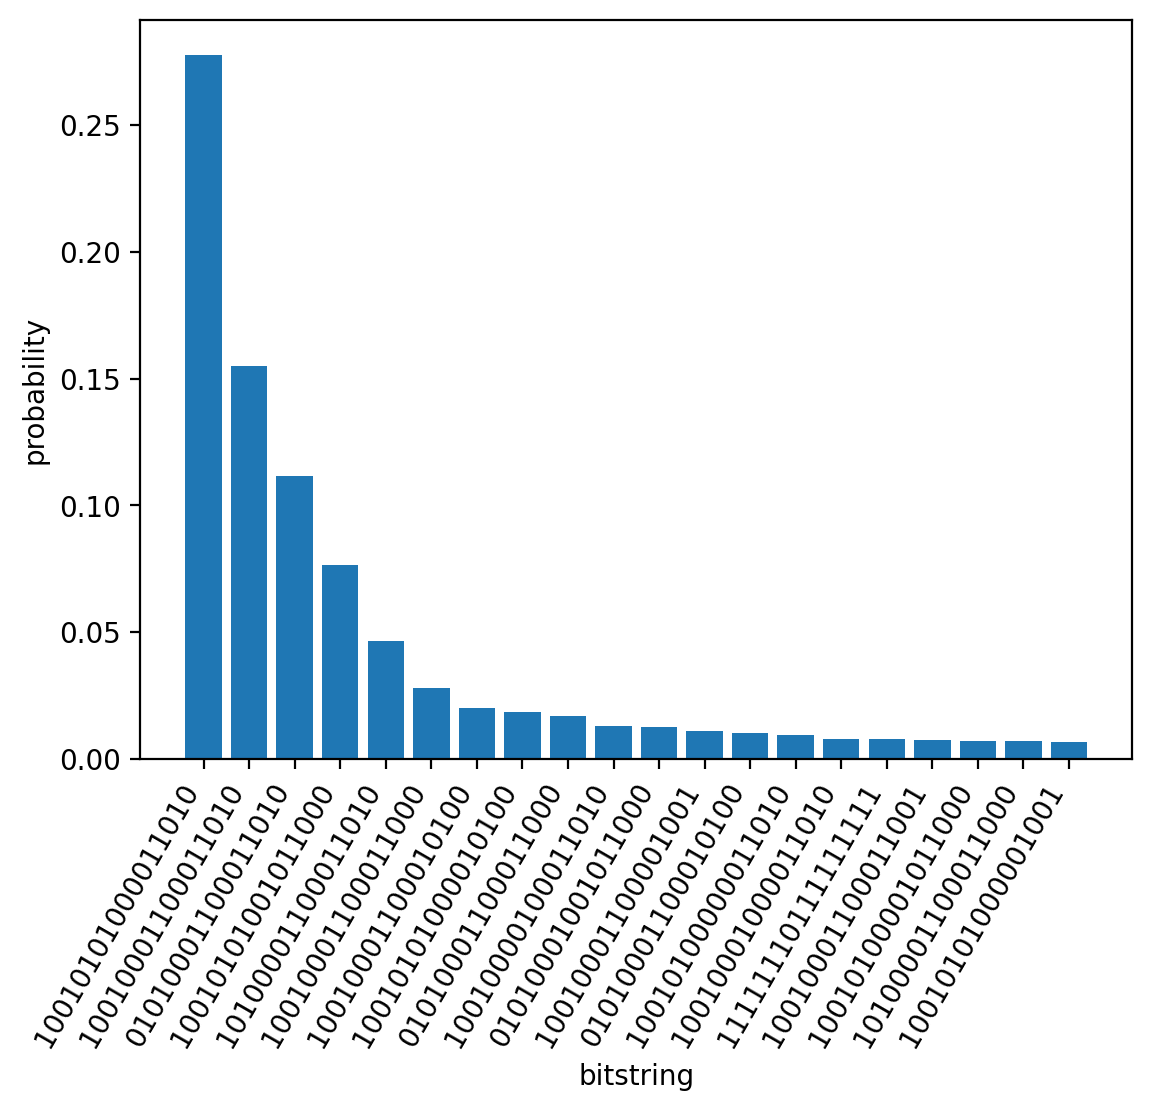

In [571]:
bitstring_hist(prob.reg; nlargest = 20)

Visulize the configuration by coloring the Rydberg excitations on the 4x4 graph. 

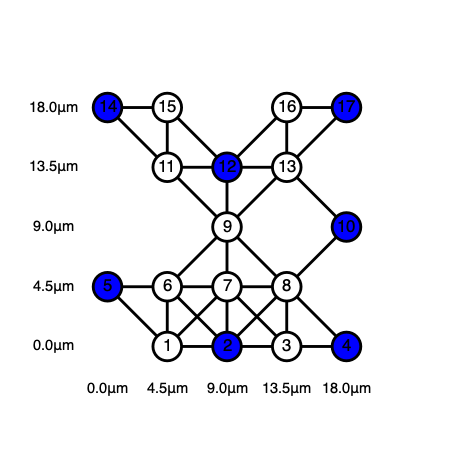

In [572]:
best_bit_strings = most_probable(prob.reg, 19)
Bloqade.plot(atomsnew, blockade_radius = 7.5; colors = [iszero(b) ? "white" : "blue" for b in best_bit_strings[1]])

Calculate mean MIS size

In [573]:
rydberg_density_sum(prob.reg)

6.848218670079905

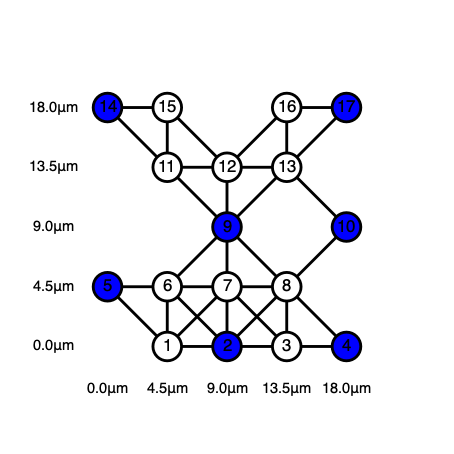

In [574]:
Bloqade.plot(atomsnew, blockade_radius = 7.5; colors = [iszero(b) ? "white" : "blue" for b in best_bit_strings[2]])

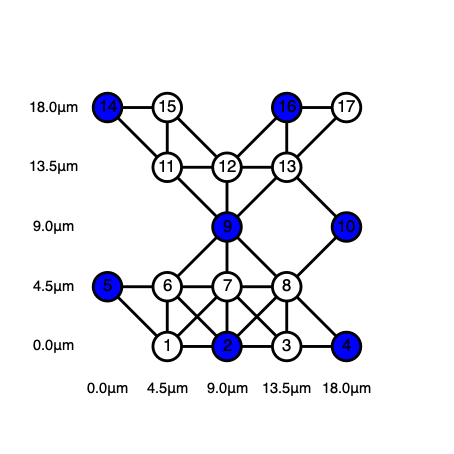

In [575]:
Bloqade.plot(atomsnew, blockade_radius = 7.5; colors = [iszero(b) ? "white" : "blue" for b in best_bit_strings[3]])

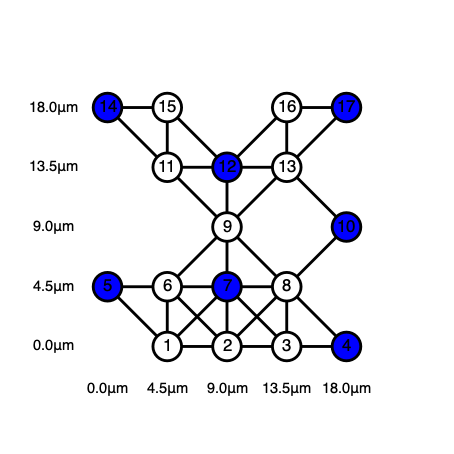

In [576]:
Bloqade.plot(atomsnew, blockade_radius = 7.5; colors = [iszero(b) ? "white" : "blue" for b in best_bit_strings[4]])

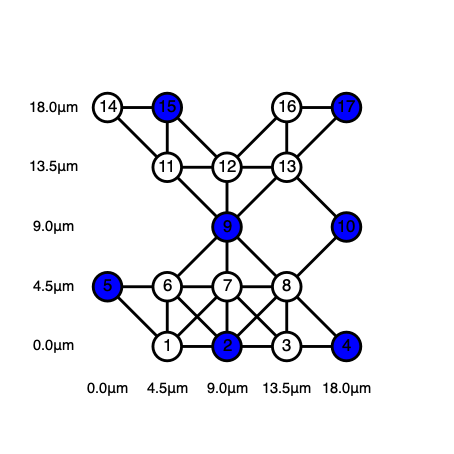

In [577]:
Bloqade.plot(atomsnew, blockade_radius = 7.5; colors = [iszero(b) ? "white" : "blue" for b in best_bit_strings[5]])

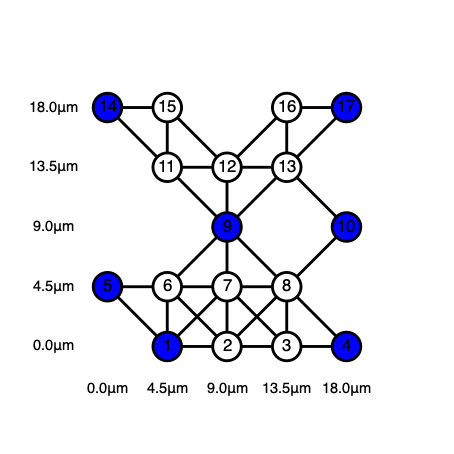

In [578]:
Bloqade.plot(atomsnew, blockade_radius = 7.5; colors = [iszero(b) ? "white" : "blue" for b in best_bit_strings[17]])

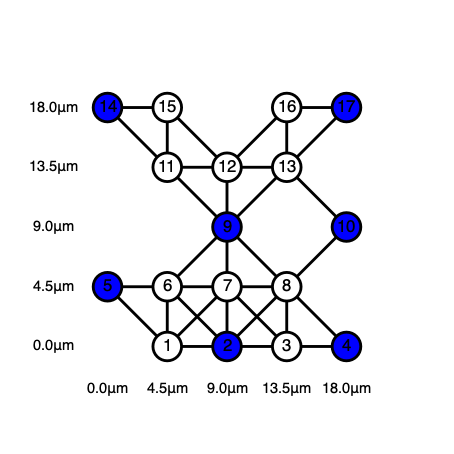

In [579]:
fixednew = mis_postprocessing(best_bit_strings[17], graphnew)
Bloqade.plot(atomsnew, blockade_radius = 7.5; colors = [iszero(b) ? "white" : "blue" for b in fixednew])